In [1]:
import os
n_jobs = 16
os.environ["OMP_NUM_THREADS"] = str(n_jobs)
import joblib
import click
import json
import time

import itertools
import collections.abc
import sys
from tqdm import tqdm
# !{sys.executable} -m pip install qiskit-machine-learning
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.optimize import minimize
# Qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit import Parameter, ParameterVector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeQuebec
from qiskit_ibm_runtime import Session, Batch
from qiskit_machine_learning.optimizers import SPSA, Minimizer


from joblib import dump, load


In [2]:
def mitarai(quantumcircuit,num_wires,paramname='x'):
    # encoding as proposed by Mitarai et al.
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_idx = i % num_features  # Calculate the feature index using modulo
        quantumcircuit.ry(np.arcsin(features[feature_idx * 2]), i)
        quantumcircuit.rz(np.arccos(features[feature_idx * 2 + 1] ** 2), i)


def double_angle(quantumcircuit, num_wires,paramname='x'):
    #  creates a circuit that encodes features into wires via angle encoding with an RY then RZ gate
    #  the features are encoded 1-1 onto the qubits
    #  if more wires are passed then features the remaining wires will be filled from the beginning of the feature list
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_index = i % num_features
        quantumcircuit.ry(features[feature_index], i)
        quantumcircuit.rz(features[feature_index], i)

def entangle_cnot(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cnot gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cx(i, 0)
        else:
            quantumcircuit.cx(i, i+1)


def entangle_cz(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cz gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cz(i, 0)
        else:
            quantumcircuit.cz(i, i+1)


def HardwareEfficient(quantumcircuit,num_wires,paramname='theta'):
    parameters = ParameterVector(paramname,num_wires*3)
    for qubit in range(num_wires):
        quantumcircuit.rx(parameters[qubit * 3], qubit)  
        quantumcircuit.rz(parameters[qubit * 3 + 1], qubit)  
        quantumcircuit.rx(parameters[qubit * 3 + 2], qubit)  
    entangle_cnot(quantumcircuit,num_wires)



In [3]:
# def circuit(nqubits):
#     qc = QuantumCircuit(nqubits)
#     mitarai(qc,nqubits)
#     entangle_cz(qc,nqubits)
#     qc.barrier()
#     mitarai(qc,nqubits,paramname='x1')
#     entangle_cz(qc,nqubits)
#     qc.barrier()
#     HardwareEfficient(qc,nqubits)
#     qc.barrier()
#     return qc


def circuit(nqubits,RUD=1):
    qc = QuantumCircuit(nqubits)
    for i in range(RUD):
        double_angle(qc,nqubits,paramname=f'x{i}')
        qc.barrier()
        HardwareEfficient(qc,nqubits,paramname=f'theta{i}')
        qc.barrier()
    return qc

In [4]:
# with open('linear_train.bin','rb') as f:
#     train = joblib.load(f)

# with open('linear_test.bin','rb') as f:
#     test = joblib.load(f)

# with open('linear_scaler.bin','rb') as f:
#     scaler = joblib.load(f)
# X_train, y_train = train['X'],train['y']
# X_test, y_test = test['X'],test['y']


# with open('PCA5_0.8_Morgan_train.bin','rb') as f:
#     bse_train = joblib.load(f)

# with open('PCA5_0.8_Morgan_test.bin','rb') as f:
#     bse_test = joblib.load(f)

# with open('PCA5_0.8_Morgan_scaler.bin','rb') as f:
#     bse_scaler = joblib.load(f)

# X_bse_train, y_bse_train = bse_train['X'],bse_train['y']
# X_bse_test, y_bse_test = bse_test['X'],bse_test['y']


# X_bse_train[np.isclose(X_bse_train,1)]=1
# X_bse_train[np.isclose(X_bse_train,-1)]=-1



# X_train, y_train = X_bse_train, y_bse_train
# X_test, y_test = X_bse_test, y_bse_test
# scaler = bse_scaler



with open('0.1_5_DDCC_train.bin','rb') as f:
    ddcc_train = joblib.load(f)

with open('0.1_5_DDCC_test.bin','rb') as f:
    ddcc_test = joblib.load(f)

with open('0.1_5_DDCC_scaler.bin','rb') as f:
    ddcc_scaler = joblib.load(f)

X_ddcc_train, y_ddcc_train = ddcc_train['X'],ddcc_train['y']
X_ddcc_test, y_ddcc_test = ddcc_test['X'],ddcc_test['y']



X_train, y_train = X_ddcc_train[0:1], y_ddcc_train[0:1]
X_test, y_test = X_ddcc_test[0:1], y_ddcc_test[0:1]
scaler = ddcc_scaler

print(X_train.shape, X_test.shape)

(1, 5) (1, 5)


In [5]:


def incremental_save_minimize(fun, x0, save_path, args=(), method='cobyla', options=None):
    """
    Minimize a function using scipy.optimize.minimize with incremental saving of parameters and loss.

    Parameters:
        fun (callable): The objective function to be minimized.
        x0 (ndarray): Initial guess.
        save_path (str): Path to save progress with joblib.
        args (tuple, optional): Extra arguments passed to the objective function.
        method (str, optional): Optimization method (default is 'BFGS').
        options (dict, optional): Options passed to scipy.optimize.minimize.

    Returns:
        result (OptimizeResult): The optimization result represented as a `OptimizeResult` object.
    """
    if os.path.exists(save_path):
        progress = load(save_path)
        x0 = progress['x']
        print("Resuming optimization from saved state.")        
    else:
        progress = {'x': x0, 'loss': None}

    def callback(x):
        # Save current parameters and function value
        progress['x'] = x
        progress['loss'] = fun(x, *args)
        dump(progress, save_path)
        print(f"Saved state: x={x}, loss={progress['loss']}")

    result = minimize(fun, x0, args=args, method=method, callback=callback, options=options)

    # Save the final result
    progress['x'] = result.x
    progress['loss'] = result.fun
    dump(progress, save_path)
    print("Optimization complete. Final state saved.")
    return result



In [6]:
num_qubits = 5
RUD = 3

In [7]:
# 
qc = circuit(num_qubits,RUD)

num_params = len([i for i in list(qc.parameters) if 'theta' in i.name]) // RUD
# x0 = 2 * np.pi * np.random.random(num_params)
generator = np.random.default_rng(12958234)
# load_params = 'partial_state_model.bin.npz'
load_params = None
if load_params!=None:
    print('Parameters loaded')
    x0 = np.load(load_params)['x0']
else:
    print('Parameters from scratch')
    x0 = np.tile(generator.uniform(-np.pi, np.pi, num_params),RUD)


# service = QiskitRuntimeService(channel="ibm_quantum", instance='pinq-quebec-hub/univ-toronto/default')
# _backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
_backend = FakeQuebec()
target = _backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=0)

qc = pm.run(qc)


observables_labels = ''.join(['I']*(num_qubits-1))+"Z"
observables = [SparsePauliOp(observables_labels)]

mapped_observables = [observable.apply_layout(qc.layout) for observable in observables]


Parameters from scratch


In [8]:
def map2qiskit(params, ansatz, hamiltonian, estimator, num_qubits, X):
    if len(X)==1:
        featparams = dict([(i,X.item()) for idx,i in enumerate(ansatz.parameters) if 'x' in i.name])
    else:
        featparams = dict([(i,X[idx % num_qubits]) for idx,i in enumerate(ansatz.parameters) if 'x' in i.name])
    
    ansatz = ansatz.assign_parameters(featparams)    
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    y_pred = result[0].data.evs[0]
    return y_pred

In [9]:
def predict(params, ansatz, hamiltonian, estimator, num_qubits, X):
    y_pred = np.array(joblib.Parallel(n_jobs=n_jobs,verbose=0)(joblib.delayed(map2qiskit)(params, ansatz, hamiltonian, estimator, num_qubits, x) for x in tqdm(X))).reshape(X.shape[0])
    return y_pred

In [10]:
def cost_func(params, ansatz, hamiltonian, estimator, num_qubits, X, y,n_jobs,cost_history_dict):
    """Return estimate of energy from estimator

    Parameters:

        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    t0=time.perf_counter()
    y_pred = predict(params, ansatz, hamiltonian, estimator, num_qubits, X)
    loss = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(loss)
    print(f"Iters. done: {cost_history_dict['iters']} Current cost: {loss} Accuracy: {r2} Time: {time.perf_counter()-t0}")
    with open('model_log.csv', 'a') as outfile:
        log = f"{time.asctime()},{cost_history_dict['iters']},{loss},{params}\n"
        outfile.write(log)
    return loss

In [11]:
def evaluate(params, ansatz, hamiltonian, estimator, num_qubits, n_jobs, X_train, y_train, X_test=None, y_test=None, plot: bool = False, title: str = 'defult',y_scaler=None):
    scores = {}
    st = time.time()
    print('Now scoring model... ')
    
    y_train_pred = predict(params, ansatz, hamiltonian, estimator, num_qubits, X_train)
    y_train_pred = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1))
    y_train = y_scaler.inverse_transform(y_train.reshape(-1, 1))

    scores['MSE_train'] = mean_squared_error(y_train, y_train_pred)
    scores['R2_train'] = r2_score(y_train, y_train_pred)
    scores['MAE_train'] = mean_absolute_error(y_train, y_train_pred)

    y_test_pred = None
    y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    if y_test is not None:
        y_test_pred = predict(params, ansatz, hamiltonian, estimator, num_qubits, X_test)
        y_test_pred = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
        scores['MSE_test'] = mean_squared_error(y_test, y_test_pred)
        scores['R2_test'] = r2_score(y_test, y_test_pred)
        scores['MAE_test'] = mean_absolute_error(y_test, y_test_pred)

    if plot:
        plt.figure()
        if y_test_pred is not None:
            plt.scatter(y_test, y_test_pred, color='b', s=10, label=f'Test, MAE = {scores["MAE_test"]:.2f}')
        plt.scatter(y_train, y_train_pred, color='r', s=10, label=f'Train, MAE = {scores["MAE_train"]:.2f}')
        plt.ylabel('Predicted')
        plt.xlabel('Actual')
        plt.axis('scaled')

        max_val = max(max(plt.xlim()), max(plt.ylim()))
        plt.xlim((0, max_val))
        plt.ylim((0, max_val))

        x_min, x_max = plt.xlim()
        y_min, y_max = plt.ylim()
        plt.plot([x_min, x_max], [y_min, y_max], 'k--', alpha=0.2, label='y=x')
        plt.legend()
        plt.savefig(title+'_plot.svg')

        if X_test.shape[1] == 1:
            plt.figure()
            plt.title(title)
            plt.scatter(X_train, y_train_pred, color='b', label='Train', s=10)
            plt.scatter(X_test, y_test_pred, color='orange', label='Test', s=10)
            plt.scatter(X_train, y_train, color='green', label='Data', s=10)
            plt.scatter(X_test, y_test, color='green', s=10)
            plt.legend()
            plt.savefig(title+'_1D_plot.svg')

    print(f'Scoring complete taking {time.time() - st} seconds. ')

    return scores, y_test_pred, y_train_pred

None


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 112.77it/s]
/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Iters. done: 1 Current cost: 0.17439754846535446 Accuracy: nan Time: 2.567248548999487
Now scoring model... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2947.51it/s]
/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3151.24it/s]


Scoring complete taking 4.736541986465454 seconds. 


/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


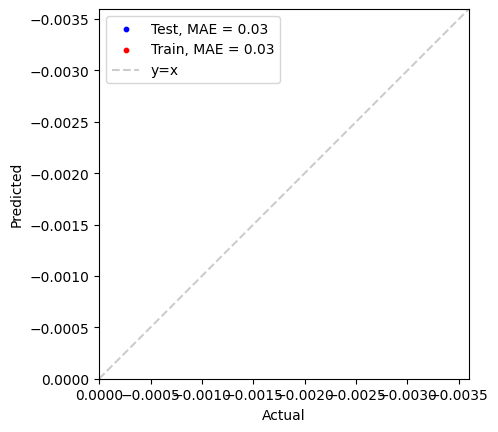

In [12]:
# estimator = StatevectorEstimator()
# job = estimator.run([(qc, mapped_observables)])
# y_pred = job.result()[0].data.evs
scores = []
with open('model_log.csv', 'w') as outfile:
    outfile.write('Time,Iteration,Cost,Parameters')
    outfile.write('\n')        

spsa = SPSA(maxiter=1)

with Session(backend=_backend) as session:
    print(session.details())
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1024.0
    estimator.options.resilience_level = 1
    
    cost_history_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }
    
    for i in range(1):
        save_file = 'partial_state_model.bin'
        
        res = minimize(cost_func,
            x0,
            args=(qc, mapped_observables, estimator, num_qubits, X_train, y_train,n_jobs,cost_history_dict),
            method="cobyla", options={'maxiter':1})        
        x0 = res.x
        loss = res.fun
        progress = {'x': x0, 'loss': loss}
        dump(progress, save_file)
        
    progress = {'x': x0, 'loss': loss}
    dump(progress, 'final_state_model.bin')
    os.remove('partial_state_model.bin') 
    scores, y_test_pred, y_train_pred = evaluate(x0,qc, mapped_observables, estimator, num_qubits, n_jobs, X_train, y_train, X_test=X_test, y_test=y_test, plot = True, title = 'A2_HWE-CNOT',y_scaler=scaler)
    
    name = 'A2_HWE-CNOT_predicted_values.csv'
    train_pred, y_train, test_pred, y_test = y_train_pred.tolist(), y_train.tolist(), y_test_pred.tolist(), y_test.tolist()
    df_train = pd.DataFrame({'Predicted': train_pred, 'Reference': y_train})
    df_train['Data'] = 'Train'
    df_test = pd.DataFrame({'Predicted': test_pred, 'Reference': y_test})
    df_test['Data'] = 'Test'
    df = pd.concat([df_train, df_test], ignore_index=True)
    df = df[['Data', 'Predicted', 'Reference']]

    df.to_csv(name, index=False)

    results_title = 'A2_HWE-CNOT_results.json'
    with open(results_title, 'w') as outfile:
        json.dump(scores, outfile)
    
